# 1-dimensional conv layer

In [1]:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    
    if p > 0:
        zero_pad = np.zeros(shape = p)
        x_padded = np.concatenate([zero_pad,
                                   x_padded,
                                   zero_pad])
        
    res = []
    for i in range(0, int(len(x) / s), s):
        res.append(np.sum(x_padded[i : i + w_rot.shape[0]] * w_rot))
        
    return np.array(res)

In [2]:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d : ', conv1d(x, w, p=2, s=1))
print('numpy result: ', np.convolve(x, w, mode = 'same'))

Conv1d :  [ 5. 14. 16. 26. 24. 34. 19. 22.]
numpy result:  [ 5 14 16 26 24 34 19 22]


# 2-dimensional conv layer

In [72]:
import numpy as np
import scipy.signal

def conv2d(X, W, p = (0, 0), s = (1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    # add padding
    n1 = X_orig.shape[0] + 2 * p[0]
    n2 = X_orig.shape[1] + 2 * p[1]
    # make 0 numpy
    X_padded = np.zeros(shape = (n1, n2))

    # insert sample into 0 numpy
    X_padded[p[0]:p[0] + X_orig.shape[0],
             p[1]:p[1] + X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0]) + 1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1]) + 1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return np.array(res)

In [73]:
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print(conv2d(X, W, p = (1, 1), s = (1, 1)))
print('scipy result: ', scipy.signal.convolve2d(X, W, mode = 'same'))

[[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
scipy result:  [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


# tensorflow DCNN

In [74]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], -1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_test.shape)

(60000, 28, 28)
(60000, 784)
(10000, 784)


In [40]:
X_valid, y_valid = X_train[50000:, :], y_train[50000:]
X_train, y_train = X_train[:50000, :], y_train[:50000]

print('훈련: ', X_train.shape, y_train.shape)
print('검증: ', X_valid.shape, y_valid.shape)
print('테스트: ', X_test.shape, y_test.shape)

훈련:  (50000, 784) (50000,)
검증:  (10000, 784) (10000,)
테스트:  (10000, 784) (10000,)


### Normalize

In [41]:
mean_vals = np.mean(X_train, axis = 0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_valid_centered = (X_valid - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val

### reshape for CNN

In [42]:
X_train_centered = X_train_centered.reshape(-1, 28, 28, 1)
X_valid_centered = X_valid_centered.reshape(-1, 28, 28, 1)
X_test_centered = X_test_centered.reshape(-1, 28, 28, 1)

### one-hot encoding Y

In [43]:
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

In [44]:
print(y_train[0], y_train_onehot[0])

5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [45]:
print('훈련: ', X_train_centered.shape, y_train_onehot.shape)
print('검증: ', X_valid_centered.shape, y_valid_onehot.shape)
print('테스트: ', X_test_centered.shape, y_test_onehot.shape)

훈련:  (50000, 28, 28, 1) (50000, 10)
검증:  (10000, 28, 28, 1) (10000, 10)
테스트:  (10000, 28, 28, 1) (10000, 10)


### Keras api

In [46]:
from tensorflow.keras import layers, models

In [47]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding = 'valid', activation = 'relu',
                        input_shape = (28, 28, 1)))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(64, (5, 5), padding = 'valid', activation = 'relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
# dropout only adpats to train (fit)
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation = 'softmax'))

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [49]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam', metrics = ['acc'])

In [50]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath = 'cnn_checkpoint.h5',
                                 monitor = 'val_loss',
                                 svae_best_only = True),
                 TensorBoard(log_dir = 'logs/{}'.format(time.asctime()))]

In [52]:
history = model.fit(X_train_centered, y_train_onehot,
                    batch_size = 64, epochs = 3,
                    validation_data = (X_valid_centered, y_valid_onehot),
                    callbacks=callback_list)

Epoch 1/3
782/782 [==============================] - 21s 27ms/step - loss: 0.0253 - acc: 0.9917 - val_loss: 0.0331 - val_acc: 0.9906
Epoch 2/3
782/782 [==============================] - 21s 27ms/step - loss: 0.0192 - acc: 0.9942 - val_loss: 0.0478 - val_acc: 0.9883
Epoch 3/3
782/782 [==============================] - 21s 27ms/step - loss: 0.0173 - acc: 0.9947 - val_loss: 0.0413 - val_acc: 0.9903


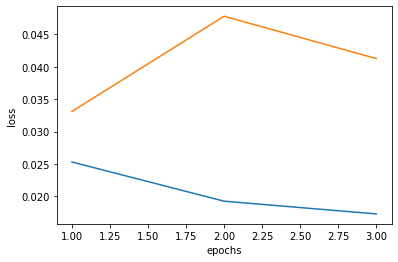

In [54]:
import matplotlib.pyplot as plt

epochs = np.arange(1, 4)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

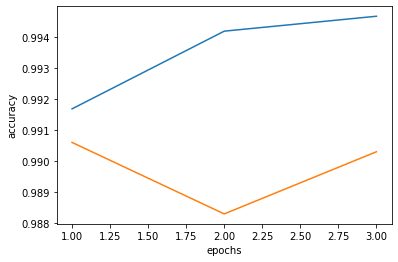

In [55]:
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [58]:
model.evaluate(X_test_centered, y_test_onehot)

313/313 [==============================] - 1s 4ms/step - loss: 0.0281 - acc: 0.9918


[0.02809285558760166, 0.9918000102043152]

In [59]:
np.argmax(model.predict(X_test_centered[:10]), axis = 1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [61]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

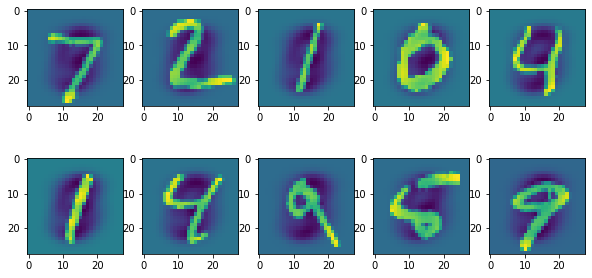

In [62]:
fig = plt.figure(figsize = (10, 5))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(X_test_centered[i].reshape(28, 28))

# visualization of conv layer

In [63]:
first_layer = model.layers[0]
print(first_layer)

In [64]:
print(model.input)

Tensor("conv2d_input:0", shape=(None, 28, 28, 1), dtype=float32)


In [65]:
first_activation = models.Model(inputs = model.input,
                                outputs = first_layer.output)
activation = first_activation.predict(X_test_centered[:10])
print(activation.shape)

(10, 24, 24, 32)


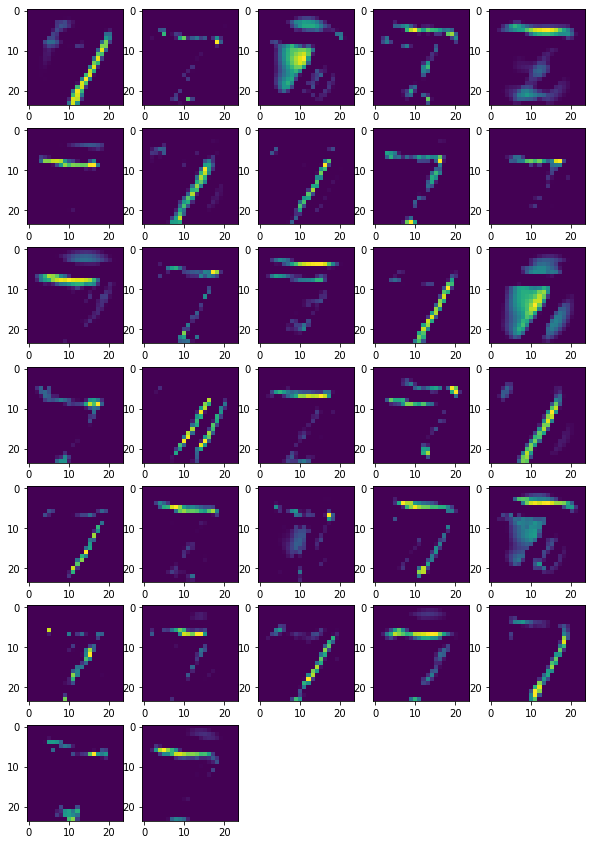

In [66]:
fig = plt.figure(figsize = (10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(activation[0, :, :, i])

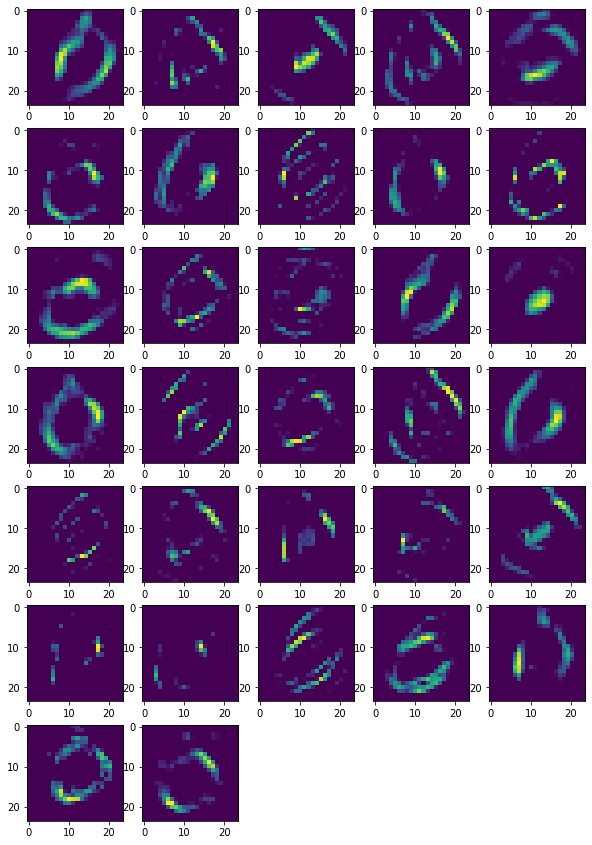

In [67]:
fig = plt.figure(figsize = (10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(activation[3, :, :, i])

### filter

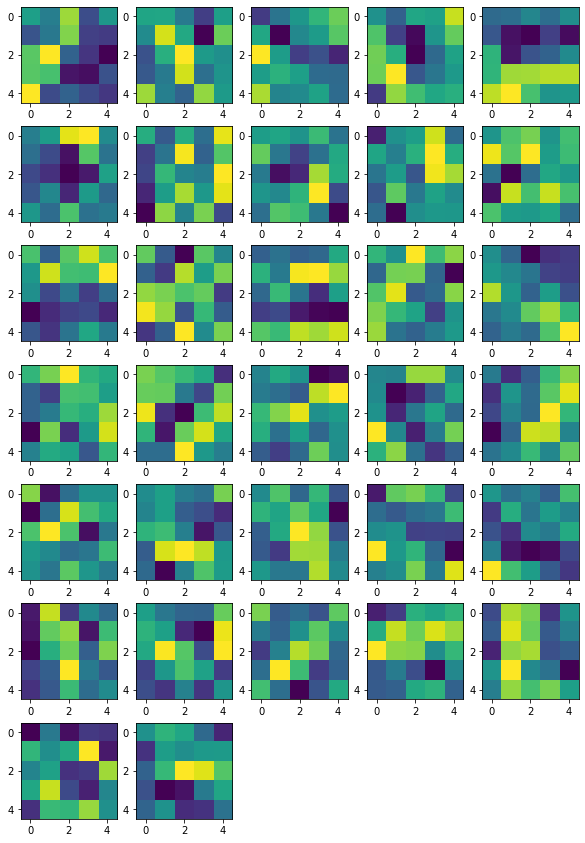

In [68]:
fig = plt.figure(figsize = (10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(first_layer.kernel[:, :, 0, i])